In [1]:
# Import dependencies

import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from transformers import BertForSequenceClassification
from transformers import BertModel
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm

In [2]:
# Load Data 

df = pd.read_csv("/kaggle/input/ecommerce-text-classification/ecommerceDataset.csv", header = None, names = ['category', 'text'])
df.head()

,category,text
0,Household,Paper Plane Design Framed Wall Hanging Motivat...
1,Household,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,Household,SAF 'UV Textured Modern Art Print Framed' Pain...
3,Household,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,Household,Incredible Gifts India Wooden Happy Birthday U...


In [3]:
# Dataset EDA

df.category.value_counts()

category
Household                 19313
Books                     11820
Electronics               10621
Clothing & Accessories     8671
Name: count, dtype: int64

In [4]:
df.text.str.len().max()

50403.0

In [5]:
# Dataframe Summary
def dataframe_summary(dataframe):
    """
    Generates a summary DataFrame containing information about null values, number of unique values,
    and duplicated rows for each column in the input DataFrame.

    Parameters:
    dataframe (pandas DataFrame): The DataFrame to be summarized.

    Returns:
    pandas DataFrame: A summary DataFrame containing information about null values, number of unique values,
    and duplicated rows for each column in the input DataFrame.
    """

    null_counts = dataframe.isnull().sum()
    unique_counts = dataframe.nunique()
    duplicated_counts = dataframe.duplicated().sum()

    summary_df = pd.DataFrame({
        'Null Values': null_counts,
        'Unique Values': unique_counts,
        'Duplicated Rows': duplicated_counts
    })

    return summary_df

dataframe_summary(df)

,Null Values,Unique Values,Duplicated Rows
category,0,4,22622
text,1,27802,22622


In [6]:
# Dropping Null Values
df.dropna(axis = 0, inplace = True)

In [7]:
# Distribution Plot for df['category']
import plotly.express as px

fig = px.histogram(df, x='category', title='Category Distribution', 
                   width=500, height=500)

fig.update_layout(
    xaxis_title='Category',
    yaxis_title='Count',
    bargap=0.25,
    xaxis_tickangle=-45,
    xaxis_tickfont_size=10,
    yaxis_tickfont_size=10
)

fig.show()

In [8]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from transformers import BertTokenizer

# Initialize the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

stop_words = set(stopwords.words('english'))

def tokenize(sentence):
    # Remove stop words
    word_tokens = word_tokenize(sentence)
    filtered_sentence = [word for word in word_tokens if word.lower() not in stop_words]
    filtered_sentence = ' '.join(filtered_sentence)
    
    # Tokenize the filtered sentence
    tokens = tokenizer.encode_plus(
        filtered_sentence,
        add_special_tokens=True,
        max_length=512,
        padding='max_length',
        truncation=True,
        return_token_type_ids=False,
        return_tensors='pt'
    )
    
    return tokens['input_ids'].squeeze(), tokens['attention_mask'].squeeze()

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [9]:
# Prepare data tensors 
ids = torch.zeros(((len(df), 512)), dtype=torch.long)
masks = torch.zeros(((len(df), 512)), dtype=torch.long)

# Iterate over each text in the 'text' column of the DataFrame
for i, txt in enumerate(df['text']):
    # Tokenize the current text using the tokenize function
    input_ids, attention_masks = tokenize(txt)
    
    # Assign the tokenized input IDs to the corresponding row in the ids tensor
    ids[i,:]=input_ids
    
    # Assign the attention masks to the corresponding row in the masks tensor
    masks[i,:]=attention_masks

In [10]:
# Label Encoding Category Column
def map(df, column_name):
    
    unique = df[column_name].unique()
    map_value = {v: i for i, v in enumerate(unique)}
    df[f"{column_name}"] = df[column_name].map(map_value)
    
    return df

In [11]:
map(df, 'category')

,category,text
0,0,Paper Plane Design Framed Wall Hanging Motivat...
1,0,"SAF 'Floral' Framed Painting (Wood, 30 inch x ..."
2,0,SAF 'UV Textured Modern Art Print Framed' Pain...
3,0,"SAF Flower Print Framed Painting (Synthetic, 1..."
4,0,Incredible Gifts India Wooden Happy Birthday U...
...,...,...
50420,3,Strontium MicroSD Class 10 8GB Memory Card (Bl...
50421,3,CrossBeats Wave Waterproof Bluetooth Wireless ...
50422,3,Karbonn Titanium Wind W4 (White) Karbonn Titan...
50423,3,"Samsung Guru FM Plus (SM-B110E/D, Black) Colou..."


In [12]:
# Converting labels to ohe 
arr = df['category'].values
labels = torch.zeros((arr.size, arr.max()+1), dtype=torch.float)
labels[torch.arange(arr.size), arr] = 1

In [13]:
# saving data
torch.save(ids, '/kaggle/working/ids.pt')
torch.save(labels, '/kaggle/working/labels.pt')
torch.save(masks, '/kaggle/working/masks.pt')

In [14]:
# Loading data
ids = torch.load('/kaggle/working/ids.pt')
masks = torch.load('/kaggle/working/masks.pt')
labels = torch.load('/kaggle/working/labels.pt')

In [15]:
# Create Custom Dataset for PyTorch Model
class EcommerceReviewDataset(Dataset):
    def __init__(self, input_ids, attention_mask, labels):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'input_ids': self.input_ids[idx],
            'attention_mask': self.attention_mask[idx],
            'labels': self.labels[idx]
        }

In [16]:
dataset = EcommerceReviewDataset(ids, masks, labels)

In [17]:
# Split the dataset into training and validation sets
from torch.utils.data import random_split

split = 0.75
train_size = int(len(dataset) * split)
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [18]:
# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# Set seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)


# Define NN Architecture
class SentimentClassifierBert(nn.Module):
    def __init__(self, bert):
        """
        Initialize the sentiment classifier model with BERT.
        
        Parameters:
        - bert (BertModel): Pretrained BERT model.
        """
        super(SentimentClassifierBert, self).__init__()
        self.bert = bert
        self.dropout = nn.Dropout(p=0.25)
        self.fc = nn.Linear(bert.config.hidden_size, 4)
        
    def forward(self, input_ids, attention_mask):
        """
        Forward pass for the sentiment classifier.
        
        Parameters:
        - input_ids (torch.Tensor): Input IDs tensor.
        - attention_mask (torch.Tensor): Attention mask tensor.
        
        Returns:
        - torch.Tensor: Output logits.
        """
        # Pass the inputs through the BERT model
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        
        # Use the pooled output from BERT
        pooled_output = outputs.pooler_output
        
        # Apply dropout
        pooled_output = self.dropout(pooled_output)
        
        # Pass through the fully connected layer to get logits
        logits = self.fc(pooled_output)
        
        return logits

In [20]:
# Initialize Bert Architecture
bert = BertModel.from_pretrained('bert-base-cased')

# Initialize NN Architecture
BertClassifier = SentimentClassifierBert(bert,)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

In [21]:
# Unfreeze the last few layers of BERT
for name, param in BertClassifier.bert.named_parameters():
    if 'layer.11' in name or 'layer.10' in name:
        param.requires_grad = True
    else:
        param.requires_grad = False

In [22]:
# Move Classifier to GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', device)
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    BertClassifier = nn.DataParallel(BertClassifier)
BertClassifier.to(device)

Device: cuda
Let's use 2 GPUs!


DataParallel(
  (module): SentimentClassifierBert(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(28996, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=T

In [23]:
from transformers import BertModel, AdamW, get_linear_schedule_with_warmup

#No of Epochs
epochs = 15

# Define criterion
criterion = nn.CrossEntropyLoss()

# Define optimizer and scheduler
optimizer = AdamW(filter(lambda p: p.requires_grad, BertClassifier.parameters()), lr=2e-5)
total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:457: FutureWarning:

This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning



In [24]:
train_loss, test_loss = [], []
train_acc, test_acc = [], []

all_epoch_preds, all_epoch_labels = [], []

for epoch in range(epochs):
    # Set the model to training mode
    BertClassifier.train()
    total_loss, total_correct = 0, 0
    total_samples = 0  # Initialize total samples for train

    # Create a progress bar for the training loop
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    # Iterate over the training batches
    for i, batch in enumerate(train_loader_tqdm):
        # Zero the gradients
        optimizer.zero_grad()

        # Move the batch data to the device
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Convert one-hot encoded labels to class indices
        labels = torch.argmax(labels, dim=1)

        # Forward pass through the model
        outputs = BertClassifier(input_ids, attention_mask)

        # Calculate the loss
        loss = criterion(outputs, labels)

        # Backpropagate the gradients
        loss.backward()

        # Update the model parameters
        optimizer.step()

        # Update the total loss, correct predictions, and total samples
        total_loss += loss.item()
        total_correct += (outputs.argmax(dim=1) == labels).sum().item()
        total_samples += len(batch["input_ids"])

        # Update the progress bar with the current loss and accuracy
        train_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}",
                                        "acc": f"{(outputs.argmax(dim=1) == labels).float().mean().item() * 100:.2f}%"})

    # Update the learning rate scheduler
    scheduler.step()

    # Calculate the average training loss and accuracy
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_correct / total_samples

    # Append the training loss and accuracy to the lists
    train_loss.append(avg_loss)
    train_acc.append(avg_acc)

    # Print the training loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {avg_loss:.4f}, Training Accuracy: {avg_acc * 100:.2f}%")

    # Set the model to evaluation mode
    BertClassifier.eval()
    total_test_loss, total_test_correct = 0, 0
    total_test_samples = 0  # Initialize total samples for test
    all_preds = []
    all_labels = []

    # Create a progress bar for the test loop
    test_loader_tqdm = tqdm(test_loader, desc=f"Epoch {epoch+1}/{epochs}", unit="batch")

    # Disable gradient calculation for the test loop
    with torch.no_grad():
        # Iterate over the test batches
        for i, batch in enumerate(test_loader_tqdm):
            # Move the batch data to the device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            # Convert one-hot encoded labels to class indices
            labels = torch.argmax(labels, dim=1)

            # Forward pass through the model
            outputs = BertClassifier(input_ids, attention_mask)

            # Calculate the loss
            loss = criterion(outputs, labels)

            # Update the total validation loss, correct predictions, and total samples
            total_test_loss += loss.item()
            total_test_correct += (outputs.argmax(dim=1) == labels).sum().item()
            total_test_samples += len(batch["input_ids"])

            # Collect predictions and true labels
            all_preds.extend(outputs.argmax(dim=1).cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update the progress bar with the current validation loss and accuracy
            test_loader_tqdm.set_postfix({"loss": f"{loss.item():.4f}",
                                           "acc": f"{(outputs.argmax(dim=1) == labels).float().mean().item() * 100:.2f}%"})

    # Calculate the average validation loss and accuracy
    avg_test_loss = total_test_loss / len(test_loader)
    avg_test_acc = total_test_correct / total_test_samples

    # Append the validation loss and accuracy to the lists
    test_loss.append(avg_test_loss)
    test_acc.append(avg_test_acc)

    # Append epoch predictions and labels to the lists
    all_epoch_preds.extend(all_preds)
    all_epoch_labels.extend(all_labels)

    # Print the validation loss and accuracy for the current epoch
    print(f"Epoch {epoch+1}/{epochs}, Test Loss: {avg_test_loss:.4f}, Test Accuracy: {avg_test_acc * 100:.2f}%")

Epoch 1/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.5386, acc=80.77%]


Epoch 1/15, Training Loss: 0.3281, Training Accuracy: 89.72%


Epoch 1/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.2074, acc=96.67%]


Epoch 1/15, Test Loss: 0.1932, Test Accuracy: 94.46%


Epoch 2/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.1672, acc=96.15%]


Epoch 2/15, Training Loss: 0.1791, Training Accuracy: 94.93%


Epoch 2/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.1953, acc=96.67%]


Epoch 2/15, Test Loss: 0.1524, Test Accuracy: 95.87%


Epoch 3/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.1241, acc=92.31%]


Epoch 3/15, Training Loss: 0.1379, Training Accuracy: 96.19%


Epoch 3/15: 100%|██████████| 394/394 [03:42<00:00,  1.77batch/s, loss=0.2098, acc=96.67%]


Epoch 3/15, Test Loss: 0.1414, Test Accuracy: 96.16%


Epoch 4/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.2888, acc=92.31%]


Epoch 4/15, Training Loss: 0.1113, Training Accuracy: 96.79%


Epoch 4/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.2669, acc=93.33%]


Epoch 4/15, Test Loss: 0.1358, Test Accuracy: 96.46%


Epoch 5/15: 100%|██████████| 1182/1182 [14:59<00:00,  1.31batch/s, loss=0.4284, acc=88.46%]


Epoch 5/15, Training Loss: 0.0873, Training Accuracy: 97.55%


Epoch 5/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.2426, acc=96.67%]


Epoch 5/15, Test Loss: 0.1181, Test Accuracy: 97.04%


Epoch 6/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.0855, acc=96.15%]


Epoch 6/15, Training Loss: 0.0710, Training Accuracy: 98.10%


Epoch 6/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.2674, acc=96.67%]


Epoch 6/15, Test Loss: 0.1063, Test Accuracy: 97.29%


Epoch 7/15: 100%|██████████| 1182/1182 [14:59<00:00,  1.31batch/s, loss=0.1652, acc=96.15%]


Epoch 7/15, Training Loss: 0.0582, Training Accuracy: 98.37%


Epoch 7/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.2704, acc=96.67%]


Epoch 7/15, Test Loss: 0.1083, Test Accuracy: 97.49%


Epoch 8/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.0141, acc=100.00%]


Epoch 8/15, Training Loss: 0.0471, Training Accuracy: 98.66%


Epoch 8/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.3064, acc=96.67%]


Epoch 8/15, Test Loss: 0.1137, Test Accuracy: 97.29%


Epoch 9/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.1962, acc=96.15%]


Epoch 9/15, Training Loss: 0.0413, Training Accuracy: 98.76%


Epoch 9/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.3066, acc=96.67%]


Epoch 9/15, Test Loss: 0.0988, Test Accuracy: 97.58%


Epoch 10/15: 100%|██████████| 1182/1182 [14:59<00:00,  1.31batch/s, loss=0.0062, acc=100.00%]


Epoch 10/15, Training Loss: 0.0315, Training Accuracy: 99.09%


Epoch 10/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.3113, acc=96.67%]


Epoch 10/15, Test Loss: 0.1073, Test Accuracy: 97.64%


Epoch 11/15: 100%|██████████| 1182/1182 [14:59<00:00,  1.31batch/s, loss=0.0102, acc=100.00%]


Epoch 11/15, Training Loss: 0.0277, Training Accuracy: 99.16%


Epoch 11/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.2883, acc=96.67%]


Epoch 11/15, Test Loss: 0.1019, Test Accuracy: 97.81%


Epoch 12/15: 100%|██████████| 1182/1182 [14:59<00:00,  1.31batch/s, loss=0.0007, acc=100.00%]


Epoch 12/15, Training Loss: 0.0231, Training Accuracy: 99.23%


Epoch 12/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.3104, acc=96.67%]


Epoch 12/15, Test Loss: 0.1120, Test Accuracy: 97.57%


Epoch 13/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.0338, acc=100.00%]


Epoch 13/15, Training Loss: 0.0204, Training Accuracy: 99.38%


Epoch 13/15: 100%|██████████| 394/394 [03:41<00:00,  1.78batch/s, loss=0.2647, acc=96.67%]


Epoch 13/15, Test Loss: 0.1072, Test Accuracy: 97.76%


Epoch 14/15: 100%|██████████| 1182/1182 [15:00<00:00,  1.31batch/s, loss=0.0152, acc=100.00%]


Epoch 14/15, Training Loss: 0.0177, Training Accuracy: 99.44%


Epoch 14/15: 100%|██████████| 394/394 [03:42<00:00,  1.77batch/s, loss=0.3445, acc=96.67%]


Epoch 14/15, Test Loss: 0.1110, Test Accuracy: 97.79%


Epoch 15/15: 100%|██████████| 1182/1182 [15:01<00:00,  1.31batch/s, loss=0.0007, acc=100.00%]


Epoch 15/15, Training Loss: 0.0170, Training Accuracy: 99.41%


Epoch 15/15: 100%|██████████| 394/394 [03:42<00:00,  1.77batch/s, loss=0.3492, acc=96.67%]

Epoch 15/15, Test Loss: 0.1099, Test Accuracy: 97.93%


In [25]:
# Create a DataFrame for all epoch predictions and true labels
df_results = pd.DataFrame({"Predictions": all_epoch_preds, "True Labels": all_epoch_labels})
print(df_results.head())  # Print the first few rows of the DataFrame

# Save the DataFrame to a CSV file (optional)
df_results.to_csv('predictions_vs_true_labels.csv', index=False)

   Predictions  True Labels
0            1            1
1            0            0
2            3            3
3            0            0
4            0            0


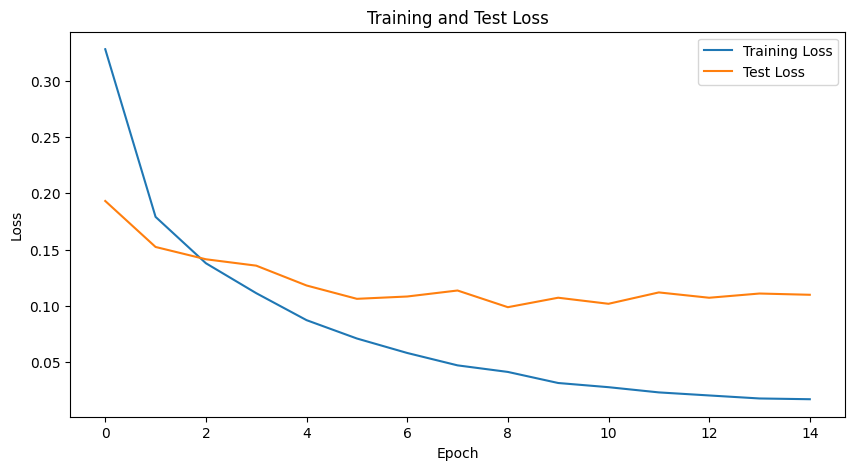

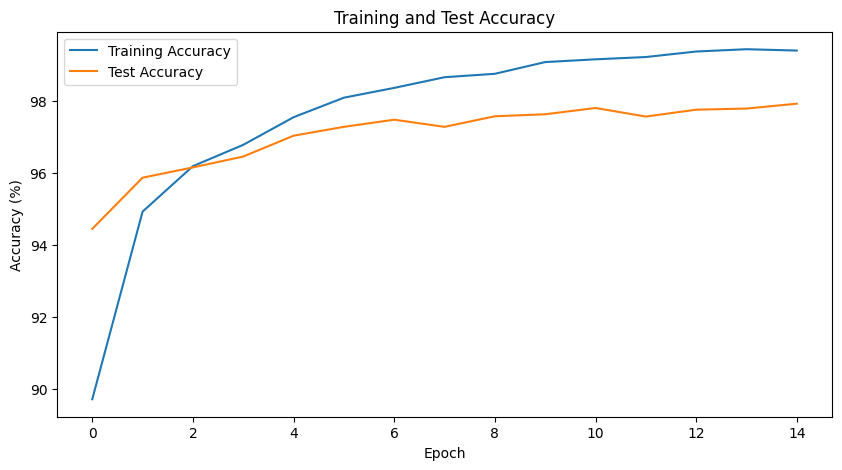

In [26]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot([acc * 100 for acc in train_acc], label='Training Accuracy')
plt.plot([acc * 100 for acc in test_acc], label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Test Accuracy')
plt.legend()
plt.show()

In [27]:
torch.save(BertClassifier.state_dict(), '/kaggle/working/sentiment_BERT_ecommerce-review_pytorch.pth')